# Movie sentiment analysis

**Data:**

The data source is Movie Sentiment project from Kaggle, including train and test datasets; In trainning data, there is a Phrase column and a Sentiment column as the result score from 0 to 4 (negative to positve); In test data, there is a Phrase column for us to analyze the sentiment of each phrase.

**Goal:**


Perform different deep learning models (ANN, CNN, RNN-LSTM) in NLP analysis on trainning data and compare model performances, and predict Phrase sentiment on test data. 

**Highlight:** 

- **Show how to prepare data for deep learning in NLP analysis**
- **Compare different deep learning models in NLP analysis**

**Reference**

Kaggel notebook: https://www.kaggle.com/chiranjeevbit/movie-review-prediction


Tensorflow helpfile: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

## Explore Data Analysis

In [1]:
## Import basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove-50d/glove.6B.50d.txt
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [3]:
## Read data
train = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip',sep="\t") 
test = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip',sep="\t") 

In [4]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [6]:
train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


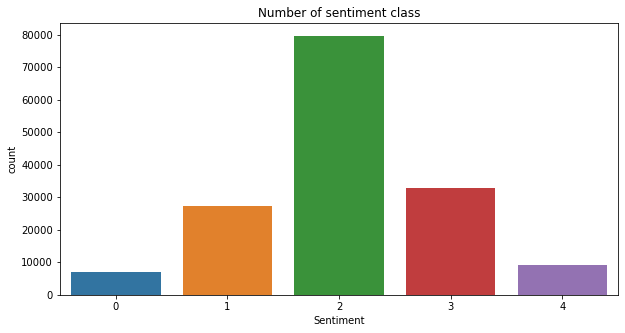

In [8]:
## Show the number of class distributed
plt.figure(figsize=(10,5))
ax=plt.axes()
ax.set_title('Number of sentiment class')
sns.countplot(x=train.Sentiment,data=train)

## Remove punctuation

In [9]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
train['Phrase1']=train.Phrase.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)).lower())
test['Phrase1']=test.Phrase.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)).lower())

In [11]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase1
0,1,1,A series of escapades demonstrating the adage ...,1,a series of escapades demonstrating the adage ...
1,2,1,A series of escapades demonstrating the adage ...,2,a series of escapades demonstrating the adage ...
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


## Split train data into train and validation datasets

In [12]:
train_shuffle=train.sample(frac=1, random_state=1)

In [13]:
split=int(0.7*train.shape[0])
train_data=train_shuffle[0:split]
valid_data=train_shuffle[split:]

## Use Glove for Wordembedding

In [14]:
words=set()
word_to_vec_map={}
with open('/kaggle/input/glove-50d/glove.6B.50d.txt','r',encoding='UTF-8') as f:
    for line in f:
        value=line.strip().split()
        word=value[0]
        words.add(word)
        word_to_vec_map[word]=np.array(value[1:],dtype=np.float64)

## Data preparation for Modelling

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow import keras

In [16]:
## fit train data into vector
tokenizer=Tokenizer()
tokenizer.fit_on_texts(train.Phrase1)
train_sequences=tokenizer.texts_to_sequences(train_data.Phrase1)
valid_sequences=tokenizer.texts_to_sequences(valid_data.Phrase1)
test_sequences=tokenizer.texts_to_sequences(test.Phrase1)

In [17]:
## Pad sequence data with 0 for same length
maxlen=train.Phrase1.apply(lambda x: len(x)).max()
train_padded=pad_sequences(train_sequences,maxlen=maxlen,padding='post',truncating='post')
valid_padded=pad_sequences(valid_sequences,maxlen=maxlen,padding='post',truncating='post')
test_padded=pad_sequences(test_sequences,maxlen=maxlen,padding='post',truncating='post')
print(train_padded.shape,valid_padded.shape,test_padded.shape)

(109242, 265) (46818, 265) (66292, 265)


In [18]:
word_index=tokenizer.word_index
vocab_size=len(word_index)
embedding_matrix=np.zeros((vocab_size+1,50))   ## for unknown word, add 1 in vocab_size

In [19]:
## Use Glove wordembedding
for word, i in word_index.items():
    embedding_vector=word_to_vec_map.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [20]:
train_x=np.array(train_padded)
train_y=np.array(train_data.Sentiment)
valid_x=np.array(valid_padded)
valid_y=np.array(valid_data.Sentiment)
test_x=np.array(test_padded)

In [21]:
N_TRAIN=len(train_x)
BATCH_SIZE=256
STEPS_PER_EPOCH=N_TRAIN/BATCH_SIZE

## decrease the learning rate when epoch increase.
lr_decay=tf.keras.optimizers.schedules.InverseTimeDecay(
    1e-2,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=1,
    staircase=False
)
histories={}

## Deep learning model comparision

### ANN

In [22]:
## Simple NN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,50,input_length=maxlen, weights=[embedding_matrix],trainable=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


In [23]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(lr_decay),metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 265, 50)           820200    
_________________________________________________________________
flatten (Flatten)            (None, 13250)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3392256   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 4,213,741
Trainable params: 3,393,541
Non-trainable params: 820,200
_________________________________________________________________


In [24]:
histories['ANN']=model.fit(train_x, train_y, epochs = 10,validation_data=(valid_x,valid_y), batch_size = 128)

Epoch 1/10
854/854 [==============================] - 6s 7ms/step - loss: 1.0737 - accuracy: 0.5569 - val_loss: 1.0355 - val_accuracy: 0.5710
Epoch 2/10
854/854 [==============================] - 6s 7ms/step - loss: 1.0282 - accuracy: 0.5752 - val_loss: 1.0423 - val_accuracy: 0.5699
Epoch 3/10
854/854 [==============================] - 6s 6ms/step - loss: 1.0023 - accuracy: 0.5839 - val_loss: 1.0419 - val_accuracy: 0.5748
Epoch 4/10
854/854 [==============================] - 6s 7ms/step - loss: 0.9794 - accuracy: 0.5944 - val_loss: 1.0719 - val_accuracy: 0.5658
Epoch 5/10
854/854 [==============================] - 6s 7ms/step - loss: 0.9581 - accuracy: 0.6037 - val_loss: 1.0672 - val_accuracy: 0.5725
Epoch 6/10
854/854 [==============================] - 6s 7ms/step - loss: 0.9364 - accuracy: 0.6127 - val_loss: 1.0981 - val_accuracy: 0.5726
Epoch 7/10
854/854 [==============================] - 6s 6ms/step - loss: 0.9148 - accuracy: 0.6207 - val_loss: 1.1117 - val_accuracy: 0.5682
Epoch 

In [25]:
colors=['blue','green']
def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

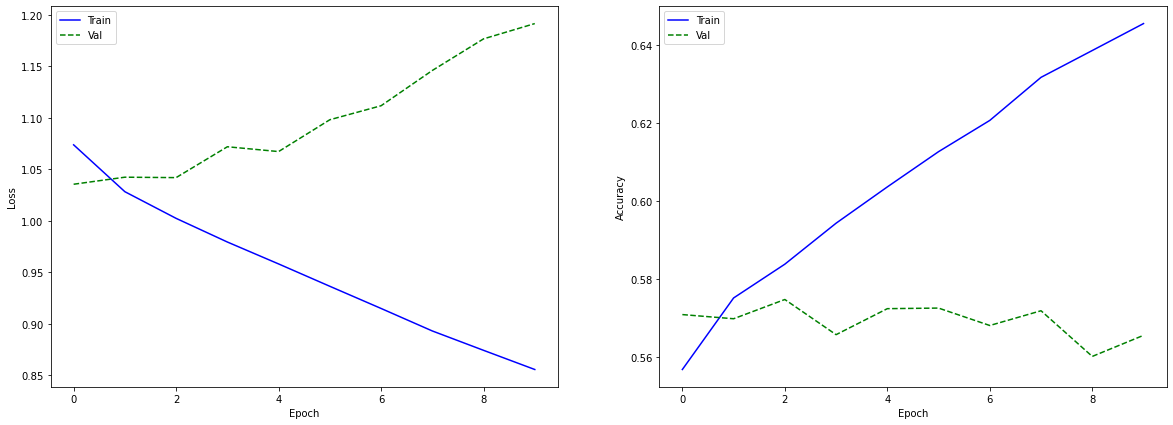

In [26]:
plt.figure(figsize=(20,7))
plot_metrics(histories['ANN'])

### Convolution NN

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,50,input_length=maxlen, weights=[embedding_matrix],trainable=False),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(128, 2, padding='same',activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(lr_decay),metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 265, 50)           820200    
_________________________________________________________________
conv1d (Conv1D)              (None, 265, 128)          12928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 132, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16896)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               4325632   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

In [28]:
histories['CNN']=model.fit(train_x, train_y, epochs = 10,validation_data=(valid_x,valid_y), batch_size = 256)

Epoch 1/10
427/427 [==============================] - 6s 14ms/step - loss: 1.0811 - accuracy: 0.5577 - val_loss: 1.0013 - val_accuracy: 0.5836
Epoch 2/10
427/427 [==============================] - 6s 14ms/step - loss: 1.0036 - accuracy: 0.5823 - val_loss: 0.9961 - val_accuracy: 0.5884
Epoch 3/10
427/427 [==============================] - 6s 13ms/step - loss: 0.9840 - accuracy: 0.5901 - val_loss: 0.9818 - val_accuracy: 0.5921
Epoch 4/10
427/427 [==============================] - 6s 14ms/step - loss: 0.9666 - accuracy: 0.5979 - val_loss: 0.9744 - val_accuracy: 0.5930
Epoch 5/10
427/427 [==============================] - 6s 14ms/step - loss: 0.9509 - accuracy: 0.6028 - val_loss: 0.9716 - val_accuracy: 0.5980
Epoch 6/10
427/427 [==============================] - 6s 14ms/step - loss: 0.9351 - accuracy: 0.6096 - val_loss: 0.9771 - val_accuracy: 0.5926
Epoch 7/10
427/427 [==============================] - 7s 15ms/step - loss: 0.9213 - accuracy: 0.6137 - val_loss: 0.9737 - val_accuracy: 0.5976

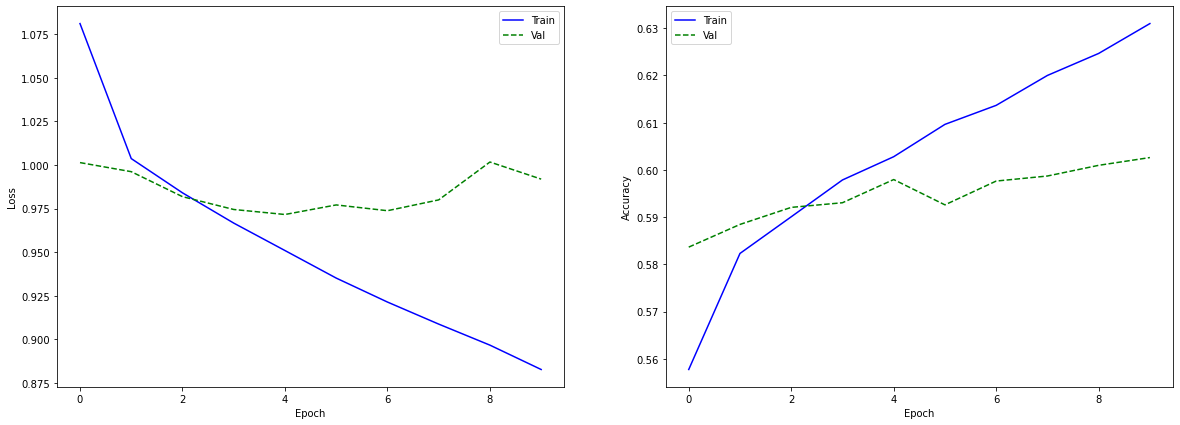

In [29]:
plt.figure(figsize=(20,7))
plot_metrics(histories['CNN'])

### RNN-LSTM, GRU

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,50,input_length=maxlen, weights=[embedding_matrix],trainable=False),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(256),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(125, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(lr_decay),metrics='accuracy')
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 265, 50)           820200    
_________________________________________________________________
lstm (LSTM)                  (None, 265, 256)          314368    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_4 (Dense)              (None, 125)               32125     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 630       
Total params: 1,692,635
Trainable params: 872,435
Non-trainable params: 820,200
_________________________________________________________________


In [31]:
histories['LSTM_1']=model.fit(train_x, train_y, epochs = 10,validation_data=(valid_x,valid_y), batch_size = 128)

Epoch 1/10
854/854 [==============================] - 71s 83ms/step - loss: 1.3062 - accuracy: 0.5051 - val_loss: 1.2846 - val_accuracy: 0.5145
Epoch 2/10
854/854 [==============================] - 70s 82ms/step - loss: 1.2888 - accuracy: 0.5080 - val_loss: 1.2810 - val_accuracy: 0.5145
Epoch 3/10
854/854 [==============================] - 70s 82ms/step - loss: 1.2871 - accuracy: 0.5080 - val_loss: 1.2808 - val_accuracy: 0.5145
Epoch 4/10
854/854 [==============================] - 70s 82ms/step - loss: 1.2866 - accuracy: 0.5080 - val_loss: 1.2792 - val_accuracy: 0.5145
Epoch 5/10
854/854 [==============================] - 70s 82ms/step - loss: 1.2861 - accuracy: 0.5080 - val_loss: 1.2795 - val_accuracy: 0.5145
Epoch 6/10
854/854 [==============================] - 69s 81ms/step - loss: 1.2861 - accuracy: 0.5080 - val_loss: 1.2790 - val_accuracy: 0.5145
Epoch 7/10
854/854 [==============================] - 69s 81ms/step - loss: 1.2862 - accuracy: 0.5080 - val_loss: 1.2791 - val_accuracy:

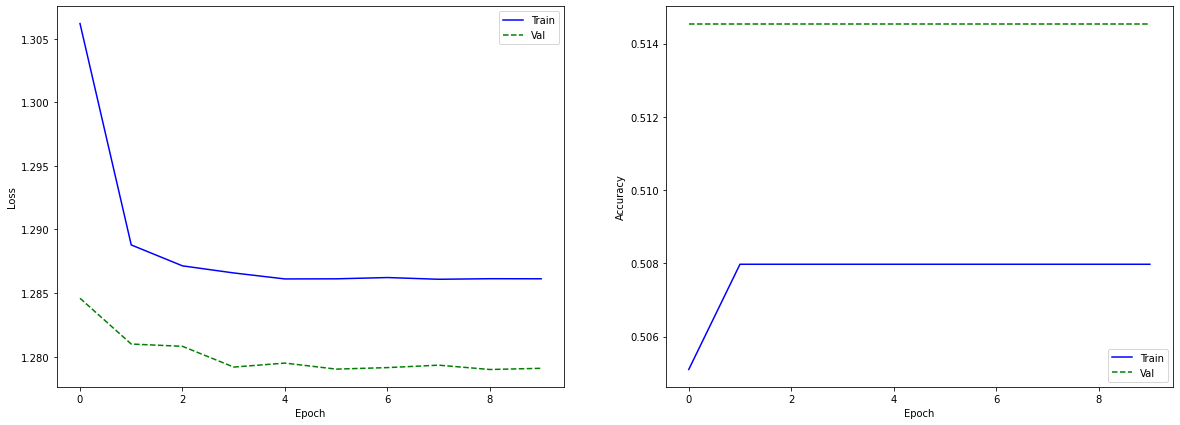

In [32]:
plt.figure(figsize=(20,7))
plot_metrics(histories['LSTM_1'])

### Bidirectional LSTM

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,50,input_length=maxlen, weights=[embedding_matrix],trainable=False),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(lr_decay),metrics='accuracy')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 265, 50)           820200    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                21248     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285      
Total params: 859,373
Trainable params: 39,173
Non-trainable params: 820,200
_________________________________________________________________


In [34]:
histories['LSTM_2']=model.fit(train_x, train_y, epochs = 10,validation_data=(valid_x,valid_y), batch_size = 256)

Epoch 1/10
427/427 [==============================] - 17s 41ms/step - loss: 1.0147 - accuracy: 0.5816 - val_loss: 0.9613 - val_accuracy: 0.5980
Epoch 2/10
427/427 [==============================] - 17s 40ms/step - loss: 0.9493 - accuracy: 0.6069 - val_loss: 0.9399 - val_accuracy: 0.6090
Epoch 3/10
427/427 [==============================] - 15s 36ms/step - loss: 0.9206 - accuracy: 0.6167 - val_loss: 0.9272 - val_accuracy: 0.6149
Epoch 4/10
427/427 [==============================] - 15s 36ms/step - loss: 0.9044 - accuracy: 0.6236 - val_loss: 0.9166 - val_accuracy: 0.6197
Epoch 5/10
427/427 [==============================] - 18s 42ms/step - loss: 0.8872 - accuracy: 0.6324 - val_loss: 0.9187 - val_accuracy: 0.6195
Epoch 6/10
427/427 [==============================] - 15s 36ms/step - loss: 0.8748 - accuracy: 0.6353 - val_loss: 0.9123 - val_accuracy: 0.6268
Epoch 7/10
427/427 [==============================] - 15s 36ms/step - loss: 0.8663 - accuracy: 0.6392 - val_loss: 0.9125 - val_accuracy:

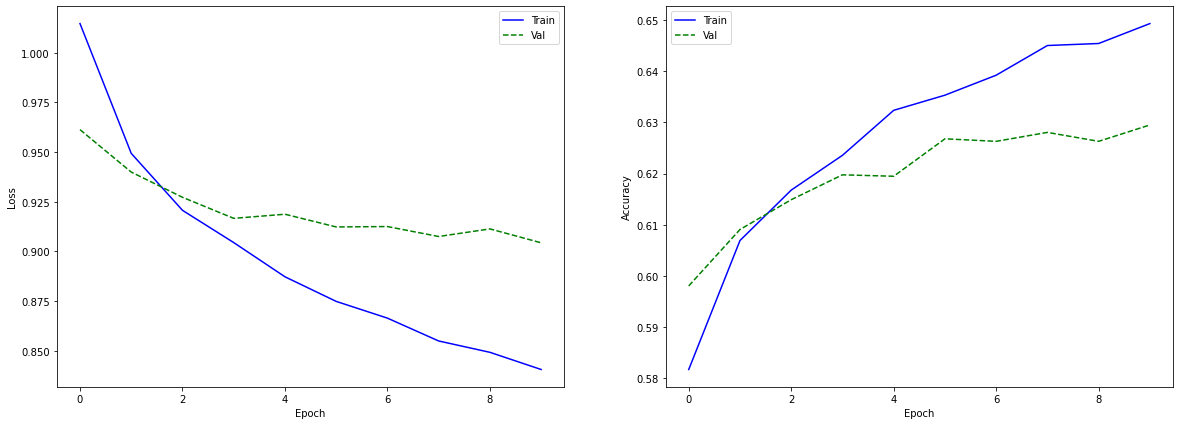

In [35]:
plt.figure(figsize=(20,7))
plot_metrics(histories['LSTM_2'])

Bidirectional LSTM tunning

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,50,input_length=maxlen, weights=[embedding_matrix],trainable=False),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(lr_decay),metrics='accuracy')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 265, 50)           820200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 265, 128)          58880     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1285      
Total params: 1,012,205
Trainable params: 192,005
Non-trainable params: 820,200
________________________________________

In [37]:
histories['LSTM_3']=model.fit(train_x, train_y, epochs = 10,validation_data=(valid_x,valid_y), batch_size = 256)

Epoch 1/10
427/427 [==============================] - 43s 102ms/step - loss: 1.0020 - accuracy: 0.5869 - val_loss: 0.9190 - val_accuracy: 0.6171
Epoch 2/10
427/427 [==============================] - 41s 97ms/step - loss: 0.9414 - accuracy: 0.6120 - val_loss: 0.9010 - val_accuracy: 0.6206
Epoch 3/10
427/427 [==============================] - 42s 99ms/step - loss: 0.8533 - accuracy: 0.6464 - val_loss: 0.8622 - val_accuracy: 0.6428
Epoch 4/10
427/427 [==============================] - 42s 99ms/step - loss: 0.8119 - accuracy: 0.6638 - val_loss: 0.8486 - val_accuracy: 0.6501
Epoch 5/10
427/427 [==============================] - 42s 98ms/step - loss: 0.7784 - accuracy: 0.6768 - val_loss: 0.8392 - val_accuracy: 0.6577
Epoch 6/10
427/427 [==============================] - 42s 98ms/step - loss: 0.7530 - accuracy: 0.6860 - val_loss: 0.8392 - val_accuracy: 0.6550
Epoch 7/10
427/427 [==============================] - 42s 97ms/step - loss: 0.7294 - accuracy: 0.6954 - val_loss: 0.8464 - val_accuracy

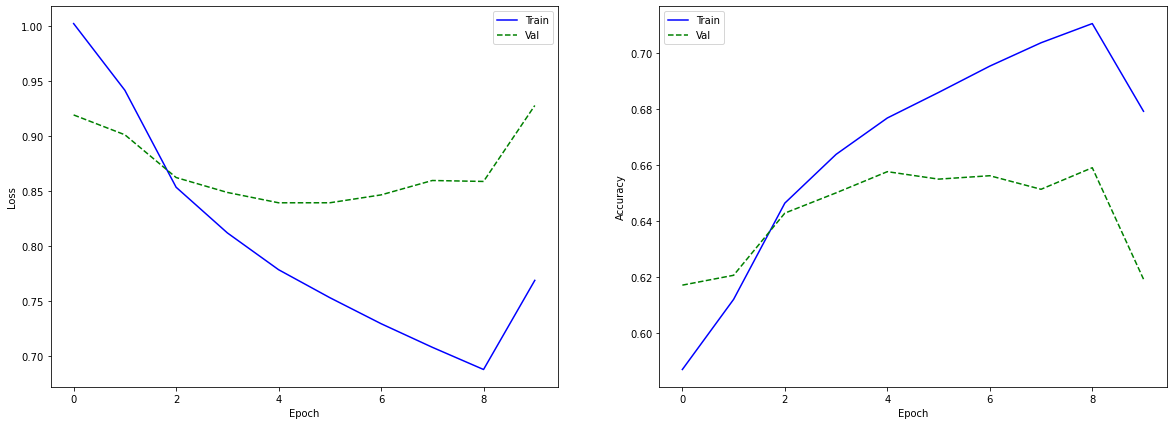

In [38]:
plt.figure(figsize=(20,7))
plot_metrics(histories['LSTM_3'])

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,50,input_length=maxlen, weights=[embedding_matrix],trainable=False),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(lr_decay),metrics='accuracy')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 265, 50)           820200    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 265, 128)          58880     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 1285      
Total params: 1,012,205
Trainable params: 192,005
Non-trainable params: 820,200
________________________________________

In [40]:
## best, 6522
histories['LSTM_4']=model.fit(train_x, train_y, epochs = 10,validation_data=(valid_x,valid_y), batch_size = 256)

Epoch 1/10
427/427 [==============================] - 43s 101ms/step - loss: 0.9997 - accuracy: 0.5875 - val_loss: 0.9227 - val_accuracy: 0.6167
Epoch 2/10
427/427 [==============================] - 41s 97ms/step - loss: 0.9347 - accuracy: 0.6132 - val_loss: 0.9268 - val_accuracy: 0.6139
Epoch 3/10
427/427 [==============================] - 42s 98ms/step - loss: 0.8752 - accuracy: 0.6357 - val_loss: 0.8574 - val_accuracy: 0.6449
Epoch 4/10
427/427 [==============================] - 42s 98ms/step - loss: 0.8225 - accuracy: 0.6574 - val_loss: 0.8420 - val_accuracy: 0.6503
Epoch 5/10
427/427 [==============================] - 42s 98ms/step - loss: 0.7864 - accuracy: 0.6728 - val_loss: 0.8519 - val_accuracy: 0.6511
Epoch 6/10
427/427 [==============================] - 42s 98ms/step - loss: 0.7597 - accuracy: 0.6839 - val_loss: 0.8487 - val_accuracy: 0.6565
Epoch 7/10
427/427 [==============================] - 41s 97ms/step - loss: 0.7353 - accuracy: 0.6934 - val_loss: 0.8454 - val_accuracy

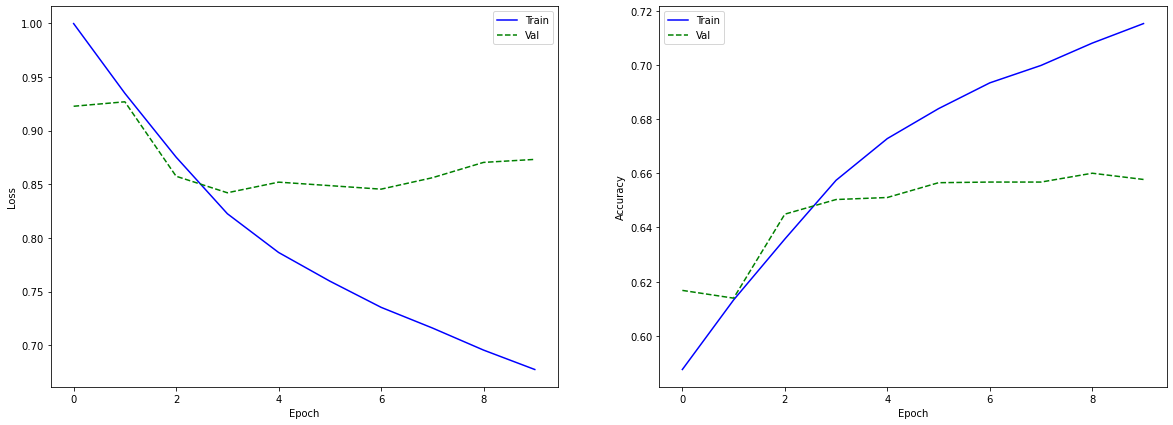

In [41]:
plt.figure(figsize=(20,7))
plot_metrics(histories['LSTM_4'])

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,50,input_length=maxlen, weights=[embedding_matrix],trainable=False),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(lr_decay),metrics='accuracy')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 265, 50)           820200    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 265, 128)          58880     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 265, 128)          98816     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [43]:
## best, 6577
histories['LSTM_5']=model.fit(train_x, train_y, epochs = 10,validation_data=(valid_x,valid_y), batch_size = 256)

Epoch 1/10
427/427 [==============================] - 69s 163ms/step - loss: 1.0407 - accuracy: 0.5727 - val_loss: 0.9496 - val_accuracy: 0.6083
Epoch 2/10
427/427 [==============================] - 65s 152ms/step - loss: 0.9222 - accuracy: 0.6180 - val_loss: 0.8795 - val_accuracy: 0.6364
Epoch 3/10
427/427 [==============================] - 65s 153ms/step - loss: 0.8640 - accuracy: 0.6420 - val_loss: 0.8730 - val_accuracy: 0.6422
Epoch 4/10
427/427 [==============================] - 65s 153ms/step - loss: 0.8414 - accuracy: 0.6519 - val_loss: 0.8804 - val_accuracy: 0.6321
Epoch 5/10
427/427 [==============================] - 66s 155ms/step - loss: 0.8936 - accuracy: 0.6317 - val_loss: 0.8809 - val_accuracy: 0.6361
Epoch 6/10
427/427 [==============================] - 65s 152ms/step - loss: 0.8370 - accuracy: 0.6537 - val_loss: 0.8577 - val_accuracy: 0.6445
Epoch 7/10
427/427 [==============================] - 66s 155ms/step - loss: 0.8006 - accuracy: 0.6684 - val_loss: 0.8516 - val_ac

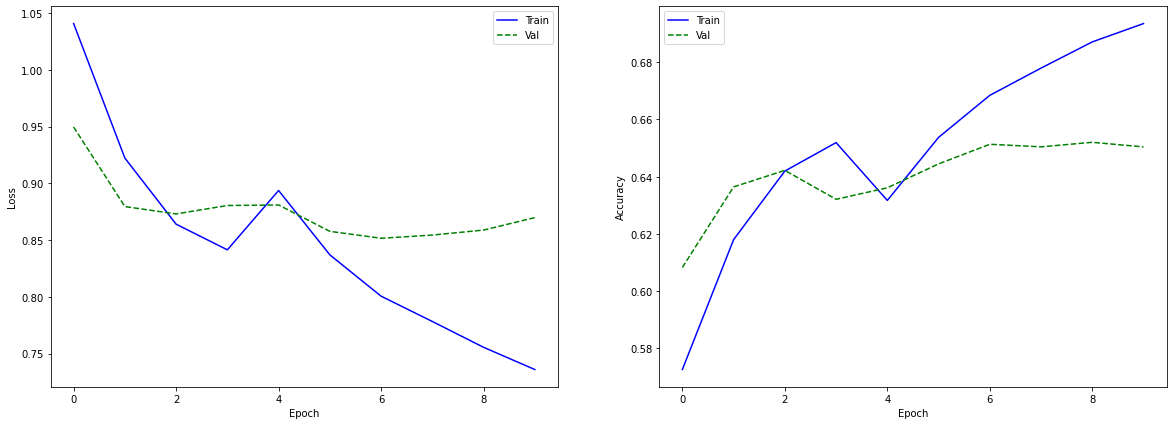

In [44]:
plt.figure(figsize=(20,7))
plot_metrics(histories['LSTM_5'])

## Submission

In [45]:
test_y=model.predict_classes(test_x)

In [46]:
sub_file = pd.read_csv('/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',sep=',')
sub_file.Sentiment=test_y
sub_file.to_csv('Submission.csv',index=False)